In [15]:
import pandas as pd
import numpy as np
import networkx as nx
import os
import pickle
import matplotlib.pyplot as plt
import vehicle_list_data
from simulation import Simulation
from vehicle_list_data import get_index_edge_totals

# Sort Pickles

In [2]:
file_path = "trials/MOST_RECENT_natalie_updated/"
pkls = os.listdir(file_path)
num_scenarios = 5
per_scenario = {str(n):[] for n in range(num_scenarios)}
for scenario in range(num_scenarios):
    for pkl in pkls:
        end_index = pkl.find('_algorithm_')
        if "scenario_"+str(scenario) in pkl or pkl[end_index-1:end_index]==str(scenario):
            per_scenario[str(scenario)].append(pkl)

per_scenario = {key:sorted(per_scenario[key]) for key in per_scenario}
per_scenario

{'0': ['natalie_updated_0_algorithm_1_05_02_2022_12_02_55.pkl',
  'natalie_updated_0_algorithm_2_05_02_2022_12_03_25.pkl',
  'natalie_updated_0_algorithm_3_05_02_2022_12_03_55.pkl',
  'natalie_updated_0_algorithm_4_05_02_2022_12_04_25.pkl',
  'natalie_updated_0_algorithm_5_05_02_2022_12_04_54.pkl'],
 '1': ['natalie_updated_1_algorithm_1_05_02_2022_12_06_00.pkl',
  'natalie_updated_1_algorithm_2_05_02_2022_12_06_31.pkl',
  'natalie_updated_1_algorithm_3_05_02_2022_12_07_02.pkl',
  'natalie_updated_1_algorithm_4_05_02_2022_12_07_34.pkl',
  'natalie_updated_1_algorithm_5_05_02_2022_12_08_06.pkl'],
 '2': ['natalie_updated_2_algorithm_1_05_02_2022_12_09_08.pkl',
  'natalie_updated_2_algorithm_2_05_02_2022_12_09_41.pkl',
  'natalie_updated_2_algorithm_3_05_02_2022_12_10_14.pkl',
  'natalie_updated_2_algorithm_4_05_02_2022_12_10_49.pkl',
  'natalie_updated_2_algorithm_5_05_02_2022_12_11_21.pkl'],
 '3': ['natalie_updated_3_algorithm_1_05_02_2022_12_12_22.pkl'],
 '4': ['natalie_updated_4_algori

In [91]:
sim_index = "0"
alg_index = 0
with open(file_path + per_scenario[sim_index][alg_index], 'rb') as inp:
    sim = pickle.load(inp)

,node,used,passed
0,2,0,0
1,3,237,0
2,4,0,0
3,5,416,1349
4,6,48,0


# Graph Scenarios over Algorithm Iterations

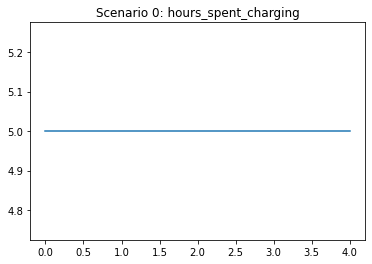

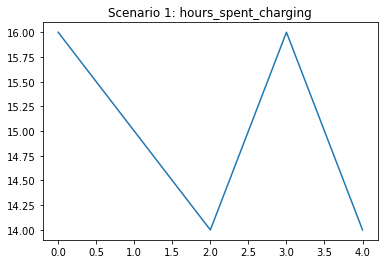

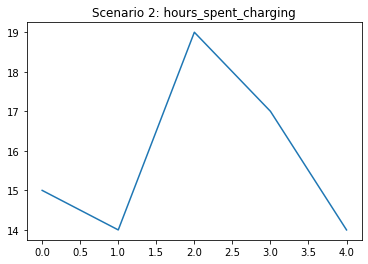

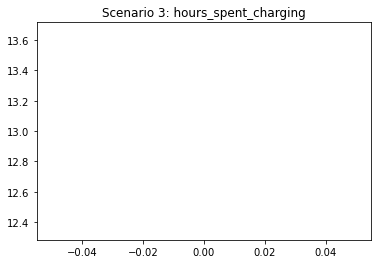

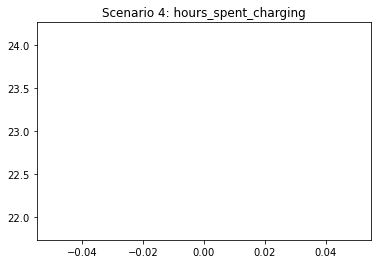

In [93]:
def graph_scenario(n, metric = "station_utilization_disp_of_avg", measurement=None):
    indices = {"min": 0, "med": 1, "max": 2, "mean": 3, "std":4}
    data = []
    for pkl in per_scenario[str(n)]:
        with open(file_path + pkl, 'rb') as inp:
            sim = pickle.load(inp)
            if measurement != None:
                data.append(sim.metrics[metric][indices[measurement]])
            else:
                data.append(sim.metrics[metric])
    plt.plot(data)
    plt.title("Scenario " + str(n) + ": " + metric)
    plt.show()

for scenario in range(num_scenarios):
    graph_scenario(scenario, metric = "hours_spent_charging", measurement = "max")

# Extract Charging Station Information

In [16]:
with open("debug_05_02_2022_20_36_34.pkl", 'rb') as inp:
    sim = pickle.load(inp)

In [17]:
def get_stations_used_passed(path):
    stations_used = []
    stations_passed = []
    for i, loc in enumerate(path):
        if i == len(path):
            break
        if "_in" in loc:
            next_loc = path[i+1]
            in_battery = loc.split("_")[1]
            out_battery = next_loc.split("_")[1]
            if "_out" in next_loc:
                node = loc.split("_")[0]
                if in_battery != out_battery:
                    stations_used.append(node)
                else:
                    stations_passed.append(node)
    return (stations_used, stations_passed)

def get_utilization_df(sim):
    station_used_counts = {node:0 for node in sim.station_g.nodes}
    station_passed_counts = {node:0 for node in sim.station_g.nodes}

    for vehicle in sim.vehicle_list:
        stations_used, stations_passed = get_stations_used_passed(vehicle.path)
        for station in stations_used:
            station_used_counts[station]+=1
        for station in stations_passed:
            station_passed_counts[station]+=1
    utilization_data = np.array([list(station_used_counts.keys()), list(station_used_counts.values()), list(station_passed_counts.values())]).T
    utilization_df = pd.DataFrame(utilization_data, columns = ["node", "used", "passed"])
    utilization_df = utilization_df.astype({"used": int, "passed": int})
    return utilization_df

def get_charging_passed_unseen(sim):
    utilization_df = get_utilization_df(sim)
    num_stations_unseen = len(utilization_df.loc[(utilization_df["used"]==0)&(utilization_df["passed"]==0)])
    num_stations_passed = len(utilization_df.loc[(utilization_df["used"]==0)&(utilization_df["passed"]!=0)])
    num_stations_charging = len(utilization_df.loc[(utilization_df["used"]!=0)])
    return (num_stations_charging, num_stations_passed, num_stations_unseen)

get_charging_passed_unseen(sim)

(30, 0, 13)

# Assess src-dst distribution

In [18]:
print("Total vehicles: ", len(sim.vehicle_list))

Total vehicles:  5826


['Oakland', 'Long Beach', 'San Diego', 'Fresno', 'Sacramento', 'Reno', 'Oregon']


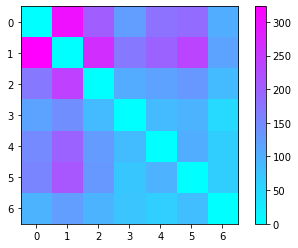

In [19]:
def plot_src_dst_matrix(sim):
    demand_nodes = list(sim.dst_dict.keys())
    num_demand_nodes = len(demand_nodes)
    destinations = {dst:0 for dst in demand_nodes}
    sources = {src:0 for src in demand_nodes}
    paths = {(src+"_src", dst+"_dst"):0 for src in demand_nodes for dst in demand_nodes}

    for vehicle in sim.vehicle_list:
        destinations[vehicle.dst]+=1
        sources[vehicle.src]+=1
        paths[(vehicle.src+"_src", vehicle.dst+"_dst")] +=1

    paths
    path_matrix = np.zeros((num_demand_nodes,num_demand_nodes))
    for r, src in enumerate(demand_nodes):
        for c, dst in enumerate(demand_nodes):
            path_matrix[r][c] = paths[(src+"_src",dst+"_dst")]
            
    plt.imshow(path_matrix, cmap='cool', interpolation='nearest')
    print(demand_nodes)
    plt.colorbar()
    plt.show()
plot_src_dst_matrix(sim)

# Assess demand (vehicles on each road)

In [20]:
edge_totals = get_index_edge_totals(sim)

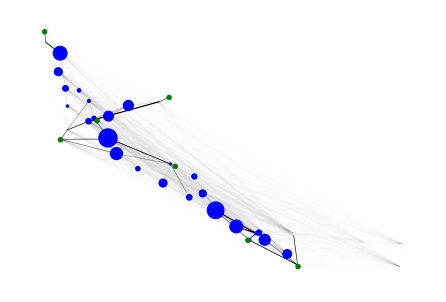

In [21]:
G = sim.station_demand_g
sim_index = 50
#colors
for node in G.nodes:
    G.nodes[node]["color"] = "blue"
    G.nodes[node]["size"] = 0
for node in nx.get_node_attributes(G,'demand'):
    G.nodes[node]["color"] = "green"
    G.nodes[node]["size"] = 20
node_color = nx.get_node_attributes(G,'color').values() 
node_size = {node: edge_totals[sim_index][(node, node)] if (node, node) in edge_totals[sim_index] else G.nodes[node]["size"] for node in G.nodes}
widths = {edge:edge_totals[sim_index][edge]/100 if edge in edge_totals[sim_index] else .002 for edge in G.edges}
pos = nx.get_node_attributes(G,'pos')
nx.draw(G, pos = pos, node_size = list(node_size.values()), width= list(widths.values()), node_color=node_color, arrows=False)

# Confirm queue charging and total at-station time

In [22]:
def get_time_at_charging_station(locations):
    sim_steps = 0
    for i, loc in enumerate(locations):
        if i == len(locations):
            break
        if "_in" in loc[0] and "_out" in loc[1]:
            in_battery = loc[0].split("_")[1]
            out_battery = loc[1].split("_")[1]
            if in_battery != out_battery:
                sim_steps+=1
    return sim_steps

In [23]:
charging_and_queue_time = []
charging_and_queue_time_sim = []
for vehicle in sim.vehicle_list:
    charging_and_queue_time.append(get_time_at_charging_station(vehicle.locations))
    charging_and_queue_time_sim.append(vehicle.queue_time)
qc_arr = np.array([charging_and_queue_time, charging_and_queue_time_sim]).T
qc_df = pd.DataFrame(qc_arr/5, columns = ["qc", "q_sim"])
print(max(qc_df["qc"]), max(qc_df["q_sim"]))

9.4 7.8


# Do vehicles with the same src dst take different paths?

In [25]:
# sim_index = "2"
# alg_index = 3
# with open(file_path + per_scenario[sim_index][alg_index], 'rb') as inp:
#     sim = pickle.load(inp)
    
pkl = "huge_queue_cost_trial_05_02_2022_15_59_14.pkl"
with open(pkl, 'rb') as inp:
    sim = pickle.load(inp)
    
def get_trip_unique_paths(sim):
    trips = {(src, dst):{} for src in demand_nodes for dst in demand_nodes}
    for vehicle in sim.vehicle_list:
        if tuple(vehicle.path) in trips[(vehicle.src, vehicle.dst)]:
            trips[(vehicle.src, vehicle.dst)][tuple(vehicle.path)]+=1
        else:
            trips[(vehicle.src, vehicle.dst)][tuple(vehicle.path)]=0
    return trips

def get_number_trip_unique_paths(sim):
    trips = get_trip_unique_paths(sim)
    return [len(trips[key]) for key in trips]


print(get_number_trip_unique_paths(sim))

NameError: name 'demand_nodes' is not defined